# Accessing Temporal Profiles Corresponding to `reV` Supply Curve Outputs

One major advantage of reV supply curve outputs is that they come with temporal capactity factor profiles that can be used for downstream analysis.
In this quick guide, we will demonstrate how to take a supply curve CSV and extract the corresponing temporal profiles form the accompanying HDF5 file.

We will demonstrate how to do this using two methods: Using the custom `rex` library (recommended) or the `h5py` library.

Let's start with a few common imports:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Using [`rex`](https://github.com/NREL/rex/) (recommended)

We recommend using the `rex` (https://github.com/NREL/rex/) library to read temporal profiles. This library was used to write the reV data to file and makes interfacing with these HDF5 file seamless. 

Let's begin by reading in the supply curve CSV using `pandas`:

In [2]:
reference_solar_supply_curve = pd.read_csv("solar_reference_supply-curve.csv")
reference_solar_supply_curve.head()

,sc_gid,res_gids,gen_gids,gid_counts,n_gids,mean_cf,mean_lcoe,mean_res,capacity,area_sq_km,...,dist_km,trans_cap_cost_per_mw,ba_str,poi_lat,poi_lon,reinforcement_poi_lat,reinforcement_poi_lon,reinforcement_cost_per_mw,reinforcement_dist_km,n_parallel_trans
0,0,"[133046, 133613, 134181, 132488, 133047]","[8552, 8811, 9071, 8299, 8553]","[489.2, 376.84, 18.48, 55.359997, 12.28]",1739,0.148431,59.853846,3.378569,331.637319,7.712496,...,0.996396,2.478331e+04,p1,48.999761,-122.724308,47.572075,-122.34181,813613.051309,229.418435,2
1,1,"[133613, 134181, 134751, 135326, 135902, 136479]","[8811, 9071, 9332, 9590, 9847, 10110]","[4.8799996, 245.76001, 207.07999, 70.68, 2.37,...",811,0.146025,60.695306,3.322941,185.340881,4.310253,...,13.957494,1.058802e+05,p1,49.000399,-122.720559,47.572075,-122.34181,813267.157762,229.381156,1
2,2,[131931],[8044],[64.799995],115,0.152294,58.353135,3.465000,22.569838,0.524880,...,7.467351,2.163971e+06,p1,48.886117,-122.750901,47.572075,-122.34181,806946.654393,216.319915,1
3,3,"[132488, 133047, 133046, 133613, 134181, 13361...","[8299, 8553, 8552, 8811, 9071, 8812, 9072, 830...","[146.36, 352.08002, 7.36, 40.16, 20.0, 477.68,...",4737,0.151318,58.716111,3.435809,847.082947,19.699603,...,138.027487,5.601646e+05,p1,47.932416,-122.127435,47.572075,-122.34181,155465.852169,54.229805,2
4,4,"[134181, 134751, 135326, 135902, 134182, 13647...","[9071, 9332, 9590, 9847, 9072, 10110, 9333, 95...","[21.480001, 34.159996, 27.0, 56.36, 36.98, 18....",1776,0.147221,60.224078,3.355201,280.270041,6.517908,...,18.529403,1.270589e+05,p1,48.797763,-122.422834,47.572075,-122.34181,722181.354190,188.072065,1


As we can see, every row of the supply curve has a unique `sc_gid` value. This is what we will use to link with the temporal profiles. Let's begin by reading in the metadata from the rep-profiles HDF5 file using the `Resource` class in `rex`:

In [3]:
from rex import Resource

with Resource("reference_ac_rep-profiles_2021.h5") as res:
    print(res.shapes)

print("Supply curve length:", len(reference_solar_supply_curve))

{'meta': (57632,), 'rep_profiles_0': (8760, 57632), 'time_index': (8760,)}
Supply curve length: 57632


As we can see, the HDF5 file contains the profiles in the "rep_profiles_0" dataset. Also, the length of the supply curve matches the spatial shape (second index) of the temporal profiles. This makes it easy to extract the profile for the point of interest: simply find the `sc_gid` of the supply curve point you are interested in and extract the profile using `sc_gid` as the index. 


### Extracting info by SC point GID

If you already know what sc point gid(s) you want to examine, extraction is straightforward:

In [4]:
# Determine what gid to examine using the "reference_solar_supply_curve"
sc_point_gid_of_interest = 34256
ind = reference_solar_supply_curve[
    reference_solar_supply_curve["sc_point_gid"] == sc_point_gid_of_interest
]["sc_gid"]

with Resource("reference_ac_rep-profiles_2021.h5") as res:
    profile = res["rep_profiles_0", :, ind]
    ti = res.time_index

profile.shape

(8760, 1)

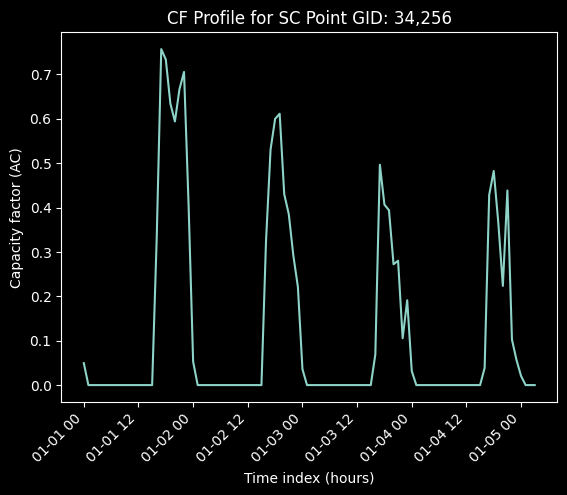

In [5]:
plt.plot(ti[:100], profile[:100])
plt.title(f"CF Profile for SC Point GID: {sc_point_gid_of_interest:,}")
plt.ylabel("Capacity factor (AC)")
plt.xlabel("Time index (hours)")
plt.xticks(rotation=45, ha="right");

You can also extract multiple profiles at the same time:

In [6]:
sc_point_gids_of_interest = [34256, 23446, 8765]
points = reference_solar_supply_curve[
    reference_solar_supply_curve["sc_point_gid"].isin(
        sc_point_gids_of_interest
    )
]
inds = points["sc_gid"]

with Resource("reference_ac_rep-profiles_2021.h5") as res:
    profiles = res["rep_profiles_0", :, inds]
    ti = res.time_index

profiles.shape

(8760, 3)

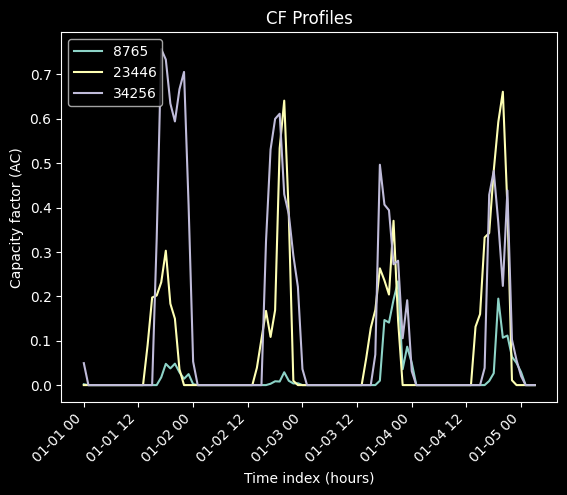

In [7]:
plt.plot(ti[:100], profiles[:100], label=points["sc_point_gid"])
plt.title(f"CF Profiles")
plt.ylabel("Capacity factor (AC)")
plt.xlabel("Time index (hours)")
plt.xticks(rotation=45, ha="right")
plt.legend(loc="upper left");

### Extracting info by Lat/Lon

Often you have a location you'd like to examine in particular. You know the lat/lon but don't know which SC point GID they belong to. In this case, you can use `rex.ResourceX` to look up the `sc_gid`!

In [22]:
from rex import ResourceX

with ResourceX("reference_ac_rep-profiles_2021.h5") as res:
    sc_gid = res.lat_lon_gid((48.346832, -124.6527))

sc_gid

16

You can then extract the supply curve information:

In [41]:
point = reference_solar_supply_curve[
    reference_solar_supply_curve["sc_gid"] == sc_gid
]
point[[
    "sc_gid", "latitude", "longitude", "capacity", "area_sq_km", "mean_cf",
    "lcot", "total_lcoe"
]]

,sc_gid,latitude,longitude,capacity,area_sq_km,mean_cf,lcot,total_lcoe
16,16,48.347,-124.653,346.15446,8.050104,0.139066,80.338917,144.342298


and the profile information just like before!

In [24]:
with Resource("reference_ac_rep-profiles_2021.h5") as res:
    profile = res["rep_profiles_0", :, sc_gid]
    ti = res.time_index

profile.shape

(8760,)

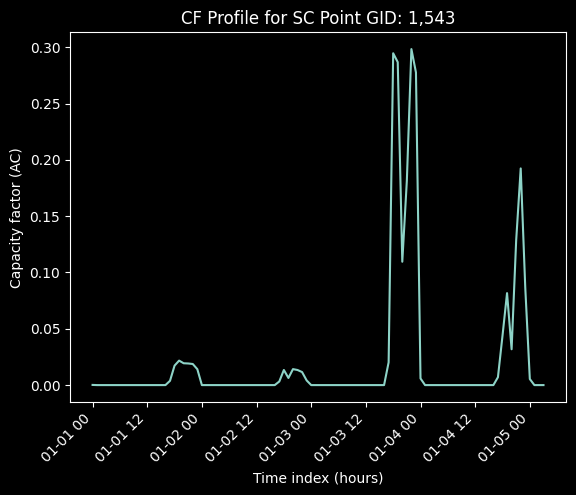

In [27]:
plt.plot(ti[:100], profile[:100])
plt.title(f"CF Profile for SC Point GID: {point['sc_point_gid'].iloc[0]:,}")
plt.ylabel("Capacity factor (AC)")
plt.xlabel("Time index (hours)")
plt.xticks(rotation=45, ha="right");

# Using `h5py`

You can also use the standard `h5py` library to read the temporal profiles.
The access pattern remains largely the same, except that you have to perform more processing as you load in the data.

Let's begin the example once agin by reading in the supply curve CSV using `pandas`:

In [8]:
reference_wind_supply_curve = pd.read_csv("wind_reference_supply-curve.csv")
reference_wind_supply_curve.head()

,sc_gid,gid,latitude,longitude,country,state,county,elevation_m,timezone,sc_point_gid,...,cost_poi_usd_per_mw,cost_export_usd_per_mw,cost_reinforcement_usd_per_mw,cost_total_trans_usd_per_mw,lcot_usd_per_mwh,lcoe_all_in_usd_per_mwh,latitude_poi,longitude_poi,latitude_reinforcement_poi,longitude_reinforcement_poi
0,1,799,48.981266,-122.20848,United States,Washington,Whatcom,325.66666,-8,799,...,15000,NaN,6.513619e+05,755896.06,inf,inf,NaN,NaN,47.572075,-122.341812
1,4,1180,48.913666,-122.00313,United States,Washington,Whatcom,389.00000,-8,1180,...,15000,NaN,6.611138e+05,854202.40,inf,inf,NaN,NaN,47.572075,-122.341812
2,6,1543,48.346832,-124.65270,United States,Washington,Clallam,172.68000,-8,1543,...,15000,NaN,1.474337e+06,1811140.60,33.76155,66.617615,NaN,NaN,47.572075,-122.341812
3,8,1566,48.975403,-120.99652,United States,Washington,Whatcom,1258.00000,-8,1566,...,15000,NaN,8.010125e+05,1167160.20,inf,inf,NaN,NaN,47.572075,-122.341812
4,9,1567,49.000840,-120.83574,United States,Washington,Whatcom,1705.00000,-8,1567,...,15000,NaN,8.010125e+05,1350633.10,inf,inf,NaN,NaN,47.572075,-122.341812


### Extracting info by SC point GID

As before, extraction is fairly straightforward if we know the `sc_point_gid` we are interested in:

In [9]:
reference_wind_supply_curve[
    reference_wind_supply_curve["sc_point_gid"] == 1543
]

,sc_gid,gid,latitude,longitude,country,state,county,elevation_m,timezone,sc_point_gid,...,cost_poi_usd_per_mw,cost_export_usd_per_mw,cost_reinforcement_usd_per_mw,cost_total_trans_usd_per_mw,lcot_usd_per_mwh,lcoe_all_in_usd_per_mwh,latitude_poi,longitude_poi,latitude_reinforcement_poi,longitude_reinforcement_poi
2,6,1543,48.346832,-124.6527,United States,Washington,Clallam,172.68,-8,1543,...,15000,NaN,1.474337e+06,1811140.6,33.76155,66.617615,NaN,NaN,47.572075,-122.341812


When we go to read the HDF5 file, we first have to look through all the datasets and shapes contained within:

In [10]:
import h5py

with h5py.File("wind_reference_bespoke.h5", "r") as fh:
    for dset in fh.keys():
        print(f"{dset}: {fh[dset].shape}")

annual_energy-2007: (52965,)
annual_energy-2008: (52965,)
annual_energy-2009: (52965,)
annual_energy-2010: (52965,)
annual_energy-2011: (52965,)
annual_energy-2012: (52965,)
annual_energy-2013: (52965,)
annual_energy-means: (52965,)
annual_gross_energy-2007: (52965,)
annual_gross_energy-2008: (52965,)
annual_gross_energy-2009: (52965,)
annual_gross_energy-2010: (52965,)
annual_gross_energy-2011: (52965,)
annual_gross_energy-2012: (52965,)
annual_gross_energy-2013: (52965,)
annual_gross_energy-means: (52965,)
annual_wake_loss_internal_kWh-2007: (52965,)
annual_wake_loss_internal_kWh-2008: (52965,)
annual_wake_loss_internal_kWh-2009: (52965,)
annual_wake_loss_internal_kWh-2010: (52965,)
annual_wake_loss_internal_kWh-2011: (52965,)
annual_wake_loss_internal_kWh-2012: (52965,)
annual_wake_loss_internal_kWh-2013: (52965,)
annual_wake_loss_internal_kWh-means: (52965,)
annual_wake_loss_internal_percent-2007: (52965,)
annual_wake_loss_internal_percent-2008: (52965,)
annual_wake_loss_internal_p

The wind bespoke output files have a lot more datasets than standard reV files. Still, we see that the datasets of interest for us are "cf_profile-\<year\>". 
Let's extract the correct one now, along with the time index. Note the extra steps we have to take to scale the profiles appropriately and get the time index converted into a `pandas.DateTimeIndex`.
The custom `rex` library perfoms all of this processing under the hood and therefore drastically reduces the complexity of I/O.

In [11]:
ind = reference_wind_supply_curve[
    reference_wind_supply_curve["sc_point_gid"] == 1543
]["sc_gid"]

with h5py.File("wind_reference_bespoke.h5", "r") as fh:
    profile_scale_factor = fh["cf_profile-2013"].attrs["scale_factor"]
    profile = fh["cf_profile-2013"][:, ind] / profile_scale_factor
    ti = pd.to_datetime(fh["time_index"][:].astype(str))

profile.shape

(8760, 1)

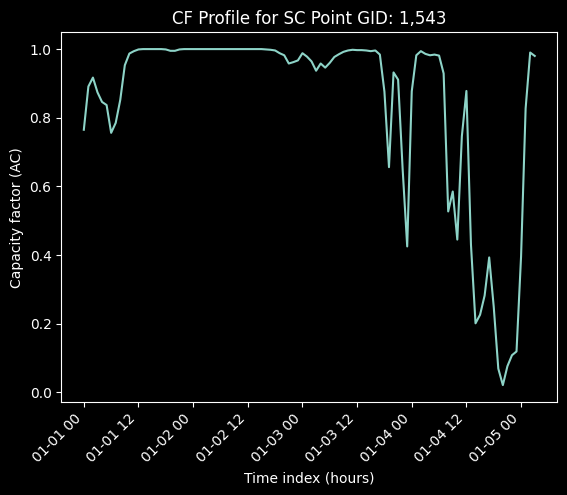

In [12]:
plt.plot(ti[:100], profile[:100])
plt.title(f"CF Profile for SC Point GID: 1,543")
plt.ylabel("Capacity factor (AC)")
plt.xlabel("Time index (hours)")
plt.xticks(rotation=45, ha="right");

Reading in multiple profiles at once can be done as well:

In [13]:
sc_point_gids_of_interest = [1543, 34357, 23399]
points = reference_wind_supply_curve[
    reference_wind_supply_curve["sc_point_gid"].isin(sc_point_gids_of_interest)
]
inds = points["sc_gid"]

with h5py.File("wind_reference_bespoke.h5", "r") as fh:
    profile_scale_factor = fh["cf_profile-2013"].attrs["scale_factor"]
    profiles = fh["cf_profile-2013"][:, inds] / profile_scale_factor
    ti = pd.to_datetime(fh["time_index"][:].astype(str))

profiles.shape

(8760, 3)

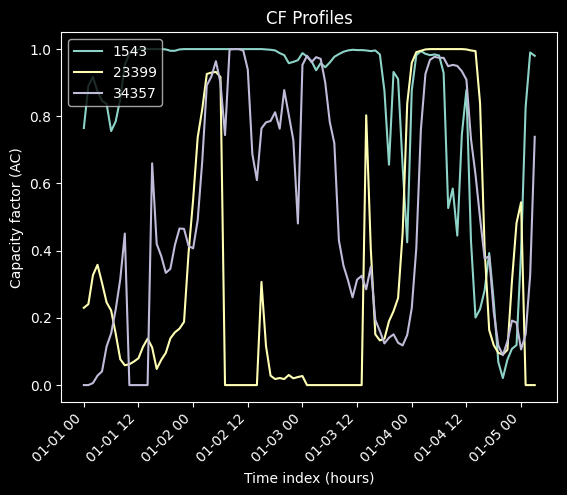

In [14]:
plt.plot(ti[:100], profiles[:100], label=points["sc_point_gid"])
plt.title(f"CF Profiles")
plt.ylabel("Capacity factor (AC)")
plt.xlabel("Time index (hours)")
plt.xticks(rotation=45, ha="right")
plt.legend(loc="upper left");

### Extracting info by Lat/Lon

Extracting info for a particular lat/lon is trickier without `rex`, but still doable. You have a few options - the simplest is to do a supply curve sort by a distance to your desired lat/lon (this is what we show below). A more sophisticated but likely more accurate approach is to use a [`cKDtree`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html) to look up the closest lat/lon pair to the point in question. This approach is not covered in this notebook.

In [38]:
import numpy as np

my_lat, my_lon = 48.346832, -124.6527

reference_wind_supply_curve["dist_to_my_point"] = np.hypot(
    reference_wind_supply_curve["latitude"] - my_lat,
    reference_wind_supply_curve["longitude"] - my_lon
)
point = reference_wind_supply_curve.sort_values(
    by="dist_to_my_point"
).iloc[[0]]
point

,sc_gid,gid,latitude,longitude,country,state,county,elevation_m,timezone,sc_point_gid,...,cost_export_usd_per_mw,cost_reinforcement_usd_per_mw,cost_total_trans_usd_per_mw,lcot_usd_per_mwh,lcoe_all_in_usd_per_mwh,latitude_poi,longitude_poi,latitude_reinforcement_poi,longitude_reinforcement_poi,dist_to_my_point
2,6,1543,48.346832,-124.6527,United States,Washington,Clallam,172.68,-8,1543,...,NaN,1.474337e+06,1811140.6,33.76155,66.617615,NaN,NaN,47.572075,-122.341812,0.0


Once you know the `sc_gid`, you can proceed as before:

In [35]:
with h5py.File("wind_reference_bespoke.h5", "r") as fh:
    profile_scale_factor = fh["cf_profile-2013"].attrs["scale_factor"]
    profile = fh["cf_profile-2013"][:, point["sc_gid"]] / profile_scale_factor
    ti = pd.to_datetime(fh["time_index"][:].astype(str))

profile.shape

(8760, 1)

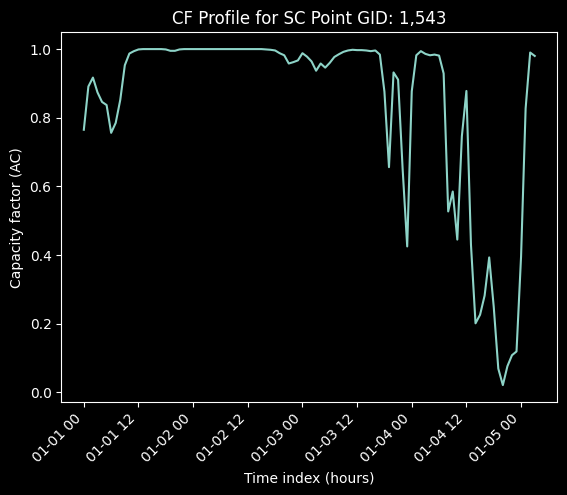

In [37]:
plt.plot(ti[:100], profile[:100])
plt.title(f"CF Profile for SC Point GID: {point['sc_point_gid'].iloc[0]:,}")
plt.ylabel("Capacity factor (AC)")
plt.xlabel("Time index (hours)")
plt.xticks(rotation=45, ha="right");